In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import *
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, ZeroPadding2D
from keras.layers import BatchNormalization
from keras import initializers
from keras import regularizers
from keras.layers.advanced_activations import LeakyReLU
from sklearn.model_selection import StratifiedKFold
from keras.utils.np_utils import to_categorical
import json
import pandas as pd
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt
K.set_image_dim_ordering('tf')

data = pd.read_json('train.json')

data = data.drop('id', 1)
data = data.drop('inc_angle', 1)



Using TensorFlow backend.
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
Y = data['is_iceberg']

data = data.drop('is_iceberg', 1)


In [3]:
X1 = data['band_1']
X2 = data['band_2']
X1 = np.array(X1)
X2 = np.array(X2)

In [4]:
X = []

for i in range(len(X1)):
    X.extend(X1[i])

In [5]:
X = np.array(X)
X = np.reshape(X, (len(X1), 75, 75, 1))

X.shape

(1604, 75, 75, 1)

In [6]:
Y = to_categorical(Y)

Y.shape

(1604, 2)

In [7]:
image_height = 75
image_width = 75

train_samples = 1300
validation_samples = 304

epochs = 2
batch_size = 32

X_train = X[:train_samples, :, : ,:]
X_train = abs(X_train/(np.max(X_train) - np.min(X_train)))
X_test = X[train_samples:, :, :, :]
X_test = abs(X_test/(np.max(X_test) - np.min(X_test)))
Y_train = Y[:train_samples, :]
Y_test = Y[train_samples:, :]

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1300, 75, 75, 1)
(304, 75, 75, 1)
(1300, 2)
(304, 2)


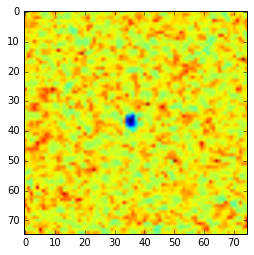

In [16]:
%matplotlib inline

sample_image = (X_train[9])

sample_image = np.reshape(elo, (75,75))
plt.imshow(sample_image)

In [9]:
model1 = Sequential()

model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, 1)))
model1.add(Conv2D(32, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Flatten())
model1.add(Dense(512, activation='relu', use_bias=True, bias_initializer='zeros'))
model1.add(Dense(2, activation='softmax'))


In [10]:
model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [15]:
model1.fit(X_train, Y_train,
              batch_size=8, validation_data=(X_test, Y_test),
              epochs=15,
                shuffle=True)

Train on 1300 samples, validate on 304 samples
Epoch 1/15
1300/1300 [==============================] - 18s - loss: 0.2555 - acc: 0.8923 - val_loss: 0.5231 - val_acc: 0.7697
Epoch 2/15
1300/1300 [==============================] - 18s - loss: 0.1745 - acc: 0.9292 - val_loss: 0.5824 - val_acc: 0.7697
Epoch 3/15
1300/1300 [==============================] - 17s - loss: 0.1138 - acc: 0.9554 - val_loss: 0.6714 - val_acc: 0.7895
Epoch 4/15
1300/1300 [==============================] - 17s - loss: 0.0850 - acc: 0.9715 - val_loss: 0.9319 - val_acc: 0.7632
Epoch 5/15
1300/1300 [==============================] - 17s - loss: 0.0372 - acc: 0.9877 - val_loss: 1.7905 - val_acc: 0.7105
Epoch 6/15
1300/1300 [==============================] - 18s - loss: 0.0378 - acc: 0.9900 - val_loss: 1.3623 - val_acc: 0.6941
Epoch 7/15
1300/1300 [==============================] - 18s - loss: 0.0072 - acc: 0.9992 - val_loss: 1.7947 - val_acc: 0.7105
Epoch 8/15
1300/1300 [==============================] - 18s - loss: 9.8

In [47]:
model1.save('100_acc.h5')

In [48]:
Yhat = model1.predict(X_test)

In [49]:
for i in range(len(Yhat)):
    Yhat[i, :] = np.round(Yhat[i, :])

In [50]:
print(np.sum(np.all(Yhat == Y_test, axis=1))/len(Yhat))

0.753289473684


In [ ]:
test = pd.read_json('test.json')

In [ ]:
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=preds
submission.to_csv('sub.csv', index=False)